In [1]:
%retina

UsageError: Line magic function `%retina` not found.


In [2]:
%matplotlib inline
from base import fetch_data, B2B, Forward, CrossDecomp, Backward, r_score
from sklearn.cross_decomposition import CCA, PLSRegression
from common import log_files, data_path
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_1samp, wilcoxon

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
import os.path as op
from scipy.stats import wilcoxon
import seaborn as sns
import pandas as pd

In [258]:
def run(subject, model_name, overwrite=False, folder='jrr'):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', folder, '%s-preproc.pkl' % subject.subject)
    save_path = op.join(data_path, '..', folder, '%s-%s.pkl' % (subject.subject, model_name))
    
    # Don't compute if already exists
    if op.isfile(save_path) and not overwrite:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    # Load and preprocess data
    if op.isfile(preproc_path) and not overwrite:
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
    else:
        meg, times, features, names, words = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names, words], f)
    
    cv = KFold(5, shuffle=True)    
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape
    
    
    # Prepare model
    grid = dict(n_components=np.unique(np.floor(np.linspace(1, n_features+1, 10)).astype(int)))
    models = dict(B2B=B2B(),
                  B2B_ensemble=B2B(ensemble=20),
                  Backward=Backward(),
                  Forward=Forward(),
                  
                  CCA=CrossDecomp(GridSearchCV(CCA(), grid, cv=5)),
                  PLS=CrossDecomp(GridSearchCV(PLSRegression(), grid, cv=5)),
                  
                  CCA1=CrossDecomp(CCA(1)),
                  CCA2=CrossDecomp(CCA(2)),
                  CCA3=CrossDecomp(CCA(3)),
                  CCA4=CrossDecomp(CCA(4)),
                  CCA6=CrossDecomp(CCA(6)),
                  
                  PLS1=CrossDecomp(PLSRegression(1)),
                  PLS2=CrossDecomp(PLSRegression(2)),
                  PLS3=CrossDecomp(PLSRegression(3)),
                  PLS4=CrossDecomp(PLSRegression(4)),
                  PLS6=CrossDecomp(PLSRegression(6)),
                 )
    model = models[model_name]

    # Loop across times
    for t in trange(n_times):
        for split, (train, test) in enumerate(cv.split(features)):
            # Preprocess
            X = StandardScaler().fit(features[train]).transform(features)
            Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])
            
            # Fit model
            model.fit(X[train], Y[train])
            
            # Compute standard scores
            H = model.score(X[test], Y[test])
            
            if t == 0 and split == 0:
                H_r = np.zeros((cv.n_splits, n_times, n_features, *H.shape))
                K_r = np.zeros((cv.n_splits, n_times, n_features, *H.shape))
            
            H_r[split, t] = H
            
            # Compute knock out scores
            K_r[split, t] = model.score_knockout(X[test], Y[test])

    # Mean scores across splits
    H_r = H_r.mean(0)
    K_r = K_r.mean(0)
    
    # Save
    print('save')
    with open(save_path, 'wb') as f:
        pickle.dump([H_r, K_r], f)

    print(time.time() - start)
    
    return H_r, K_r

In [18]:
log_files = log_files.query('task=="visual"')

# example one subject
if False:
    subject = log_files.loc[0]
    model_name = 'B2B'

    # Paths
    preproc_path = op.join(data_path, '..', 'jrr', '%s-preproc.pkl' % subject.subject)
    save_path = op.join(data_path, '..', 'jrr', '%s-%s.pkl' % (subject.subject, model_name))

    meg, times, features, names, words = fetch_data(subject)
    
    model = CrossDecomp(CCA(2))
    cv = KFold(5, shuffle=True)
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape

    # Loop across times
    for t in trange(n_times):
        for split, (train, test) in enumerate(cv.split(features)):
            # Preprocess
            X = StandardScaler().fit(features[train]).transform(features)
            Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])

            # Fit model
            model.fit(X[train], Y[train])

            # Compute standard scores
            H = model.score(X[test], Y[test])

            if t == 0 and split == 0:
                H_r = np.zeros((cv.n_splits, n_times, n_features, *H.shape))
                K_r = np.zeros((cv.n_splits, n_times, n_features, *H.shape))

            H_r[split, t] = H

            # Compute knock out scores
            K_r[split, t] = model.score_knockout(X[test], Y[test])

    # Mean scores across splits
    H_r = H_r.mean(0)
    K_r = K_r.mean(0)
elif False:
    subject_info = log_files.loc[0]
    H_r, K_r = run(subject_info, 'B2B', True)

In [19]:
folder = 'jrr'
preproc_path = op.join(data_path, '..', folder,
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

with open(preproc_path, 'rb') as f:
    _, times, features, names, _ = pickle.load(f)

In [259]:
log_path = op.join(data_path, '..', 'jrr', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=140, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', cpus_per_task=12)

jobs = list()
models = (#'B2B', 
          #'B2B_ensemble',
          #'Backward', 
          #'Forward',
          #'PLS', 
          #'CCA',
    'CCA4','PLS4'
          
)
folder = 'jrr'
#folder = 'embeddings'
for subject in trange(len(log_files)):
    for model_name in models:
        subject_info = log_files.iloc[subject]
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s.pkl' % (subject_info.subject, model_name))
        if op.isfile(save_path) and False:
            continue
        jobs.append([subject_info, model_name, True, folder])
jobs = executor.map_array(run, *zip(*jobs))

100%|██████████| 203/203 [00:00<00:00, 2127.30it/s]


In [20]:
times = np.linspace(-.100, 1., 67)

In [21]:
def get_results(model_name, folder='jrr'):
    
    H_r, K_r = list(), list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s.pkl' % (subject, model_name))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                dat = pickle.load(f)
            
            if dat[0].shape[1] != 4:
                print(save_path)
                continue
            H_r.append(dat[0])
            K_r.append(dat[1])

    if model_name == 'Forward':
        H_r = [h[:, :, :301] for h in H_r]
        K_r = [h[:, :, :301] for h in K_r]
    H_r, K_r = np.array(H_r), np.array(K_r)
    return H_r, K_r

In [246]:
models = ('Backward', 
          'Forward',
          'PLS',
          'CCA',
          'B2B', 
)

features = ('word length', 'word freq', 'word func', 'dummy')

folder = 'jrr'
data = list()
for subject in range(len(log_files)):

    subject = log_files.loc[subject, 'subject']
    for model in models:
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s.pkl' % (subject, model))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                H_r, K_r = pickle.load(f)
                if H_r.shape[1] != 4:
                    continue
                H_r = H_r
                K_r = K_r
            for effect_idx, effect in enumerate(features):

                t = .150 if effect == 'word length' else .400
                t = np.where(times>=t)[0][0]
                t = slice(t-10, t+10)
                t = slice(None, None)
                
                score = H_r[t, effect_idx] - K_r[t, effect_idx]
                score = np.mean(score, 0)
                if model in ('B2B', 'B2B_ensemble', 'Backward'):
                    score = H_r[t, :, effect_idx] - K_r[t, :, effect_idx]
                    score = np.mean(score, 0)
                data.append(dict(subject=subject, effect=effect,
                                 model=model, r=np.nanmean(score)))
                if len(np.shape(np.squeeze(score))) != 1:
                    data[-1]['max_r'] = np.max(score)

data = pd.DataFrame(data)

(-0.01, 0.05)

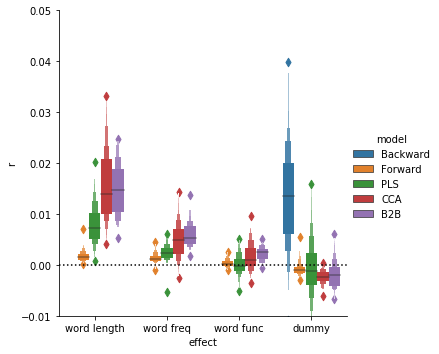

In [247]:
sns.catplot(x='effect', y='r', hue='model', kind='boxen',
            data=data)
plt.axhline(0,color='k', ls=':')
plt.ylim(-.01, 0.05)

(-0.01, 0.05)

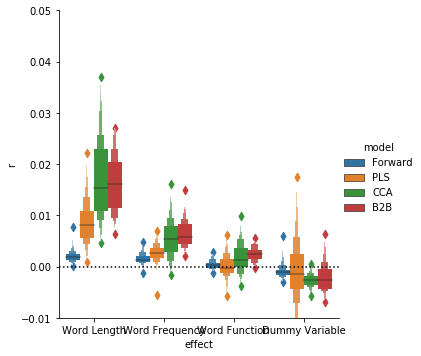

In [22]:
models = [
          #'Backward', 
          'Forward',
          'PLS',
          'CCA',
          'B2B', 
]

features = ('Word Length', 'Word Frequency', 'Word Function', 'Dummy Variable')

data = list()
for subject in range(len(log_files)):

    subject = log_files.loc[subject, 'subject']
    for model in models:
        save_path = op.join(data_path, '..', 'jrr', 
                            '%s-%s.pkl' % (subject, model))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                H_r, K_r = pickle.load(f)
                if H_r.shape[1] != 4:
                    continue
                H_r = H_r
                K_r = K_r
            
            for effect_idx, effect in enumerate(features):

                t = .150 if effect == 'word length' else .400
                t = np.where(times>=t)[0][0]
                t = np.where((times>=0.) * (times<=1.))[0]
                
                score = np.mean(H_r[t, effect_idx] - K_r[t, effect_idx], 0)
                
                if model in ('B2B', 'B2B_ensemble', 'Backward'):
                    score = score[[effect_idx,]]
                
                data.append(dict(subject=subject, effect=effect, model=model, r=np.nanmean(score)))
data = pd.DataFrame(data)

sns.catplot(x='effect', y='r', hue='model', kind='boxen',
            data=data)
plt.axhline(0,color='k', ls=':')
plt.ylim(-.01, 0.05)

/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
5.5719648223844e-17
1.0311092860836819e-16
0.06781452344009305
5.5719648223844e-17
8.494556065717916e-17
0.0006288849751696656
5.080028267285671e-16
7.454603240385837e-13
0.0014660904472031742
1.2212247398864317e-05
0.11398502106305972
0.5696895027688689


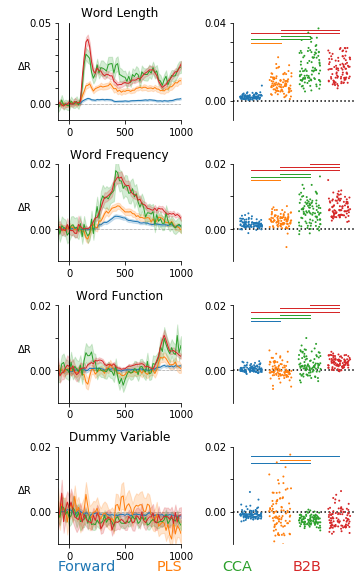

In [23]:
fig, axes = plt.subplots(4, 2, figsize=[5, 8])
for effect, (feature, ax) in enumerate(zip(features, axes)):

    for model_idx, model in enumerate(models):
        H_r, K_r = get_results(model)
        if not(len(H_r)):
            continue

        scores = H_r[:, :, effect] - K_r[:, :, effect]
        if model in ('B2B', 'B2B_ensemble', 'Backward'):
            scores = scores[:, :, [effect,]]
        scores = scores.mean(2)
        d = pd.DataFrame([dict(subject=subject, time=t, r=r)
                               for subject, score in enumerate(scores)
                               for t, r in zip(1e3*times, score)])
        sns.lineplot('time', 'r', data=d, color='C%i' % model_idx, 
                     lw=1., label=model, ax=ax[0], legend=False)

        ax[0].set_ylabel('ΔR').set_rotation(0)
        ax[0].axvline(0, color='k', lw=.5)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[0].set_title(feature)
    
    ylim = np.around(ax[0].get_ylim()[1], 2)
    ylim = max(ylim, .02)
    ax[0].set_yticks(np.arange(0, ylim+.001, .01))
    ax[0].set_ylim(-.01, ylim)
    ax[0].set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                           for f in np.arange(0, ylim+.001, .01)])
    ax[0].set_xlim(-100, 1000)
    ax[0].axhline(0, color='k', ls=':', zorder=-10, lw=.5)
    ax[0].set_xlabel('')


axes = iter(axes[:, 1])
for effect in features:
    d = data.query('effect==@effect')
    ax = next(axes)
    sns.stripplot(x='effect', y='r', hue='model', dodge=True, 
                  s=2, jitter=.3,
                  data=d, ax=ax)
    ax.axhline(0,color='k', ls=':')
    ax.legend().set_visible(False)
    ylim = np.around(ax.get_ylim()[1], 2)
    ylim = max(ylim, .02)
    ax.set_ylim(-.01, ylim)
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else '' 
                        for f in np.arange(0, ylim+.001, .01)])
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_xlabel('')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # statistical comparison
    if effect == 'dummy':
        pass
    space = np.ptp(ax.get_ylim()) / 30
    k = 0
    for idx, m1 in enumerate(models):
        
        for jdx, m2 in enumerate(models[:idx]):
            r = list()
            for _, subject in d.query('model in [@m1, @m2]').groupby('subject'):
                if len(subject)==2:
                    r.append(subject.r.values)
            r1, r2 = np.transpose(r)
            u, p = wilcoxon(r1, r2)
            if m1 == 'B2B':
                print(p)
            if p < .05:
                k += 1
                y = .7 * ylim + k * space
                if np.median(r1) < np.median(r2):
                    color = 'C%i' % idx
                else:
                    color = 'C%i' % jdx
                ax.plot(np.linspace(-.3, .3, 4)[[idx, jdx]], 
                        [y, y], color=color, lw=1.)

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(4)]
lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
leg = plt.figlegend(lines, ['',] + models, loc=(0, -0), 
                    ncol=5, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False)

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    
fig.tight_layout()

/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl


<Figure size 576x576 with 0 Axes>

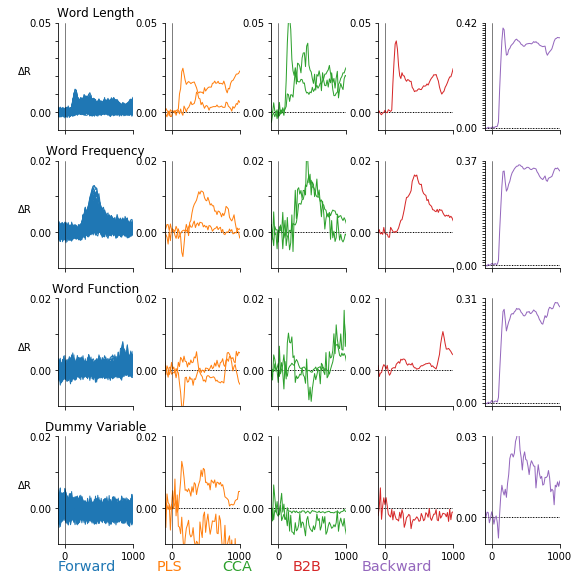

In [39]:
models = [
          'Forward',
          'PLS',
          'CCA',
          'B2B', 
          'Backward', 
]
fig = plt.figure(figsize=[8, 8])
fig, axes = plt.subplots(4, 5, figsize=[8, 8], sharex=True)
for effect, (feature, axs) in enumerate(zip(features, axes)):

    for model_idx, (model, ax) in enumerate(zip(models, axs)):
        
        #ax = axs[model_idx]
        H_r, K_r = get_results(model)
        if not(len(H_r)):
            continue

        scores = H_r[:, :, effect] - K_r[:, :, effect]
        if model in ('B2B', 'B2B_ensemble', 'Backward'):
            scores = scores[:, :, [effect,]]
        scores = scores.mean(0)
        
        ax.plot(times*1e3, scores, color='C%i' % model_idx, 
                lw=1.)

        ax.set_ylabel('ΔR').set_rotation(0)
        ax.axvline(0, color='k', lw=.5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if model_idx == 0:
            ax.set_title(feature)
        if model_idx != 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        ax.axhline(0, color='k', lw=1, zorder=-1, ls=':')
        
        ax.set_xlim(-100, 1000)
        if feature == 'Word Length' and model != 'Backward':
            ax.set_ylim(-.01, .05)
        elif model != 'Backward':
            ax.set_ylim(-.01, .02)
    
        ylim = np.around(ax.get_ylim()[1], 2)
        ax.set_yticks(np.arange(0, ylim+.001, .01))
        ax.set_ylim(-.01, ylim)
        ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                               for f in np.arange(0, ylim+.001, .01)])
        ax.set_xlim(-100, 1000)
        ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
        ax.set_xlabel('')

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(5)]
lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
leg = plt.figlegend(lines, ['',] + models, loc=(0, -0), 
                    ncol=6, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False)

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    
fig.tight_layout(w_pad=-1)